# Read CSV File

* Import CSV File using CSV Module

* Read CSV File and push data to `students_by_groups` dictionary

* `students_by_groups` is a dictionary where its keys are `tutorial_group` columns in the CSV file, while the values are objects of `TutorialGroup` datatype

* The TutorialGroup datatype contains an arrays of `Student` object

* Each `Student` object has the same parameters as the original data

## Example:

If a student has the following format:

```py
{
    'tutorial_group': "G-1",
    'student_id': 5002,
    'school': "CCDS",
    'name': "Aarav Singh",
    'gender': "Male",
    'CGPA': 4.02
}
```

Then the `students_by_groups` would look like this:

```py
students_by_groups = {
    'G-1': TutorialGroup(group_id = 1)
}

students_by_groups['G-1'].students = [
    Student(tutorial_group = 'G-1', student_id = 5002, school='CCDS', name='Aarav Singh', gender='Male', CGPA=4.02)
]
```

## Import required dependencies

In [120]:
import csv  # For reading and writing csv files
import math  # For ln function we use later
from typing import Dict, List  # For type hints
import random  # For random number generation
import matplotlib.pyplot as plt  # For plotting
import traceback  # For debugging

# We will try to construct OOP Classes for better formatting and nested functions

$$\color{green}{\Huge{\textbf{Student class}}}$$

In [121]:
class Student:
    def __init__(
        self,
        group_id: str,
        student_id: int,
        school: str,
        name: str,
        gender: str,
        CGPA: float = 4.5,
    ):
        self.group_id = group_id
        self.student_id = student_id
        self.school = school
        self.name = name
        self.gender = gender
        self.cgpa = CGPA

    def __str__(self):
        return (
            f"{self.student_id}, {self.school}, {self.name}, {self.gender}, {self.cgpa}"
        )

$$\color{green}{\Huge{\textbf{Tutorial Group Class}}}$$

In [122]:
class TutorialGroup:
    def __init__(self, group_id: str):
        self.group_id = group_id
        self.students: list[Student] = []

    def __str__(self):
        return f"{self.group_id}:\n{[str(student) for student in self.students]}"

    def add_student(self, student: Student):
        self.students.append(student)

## Read and store data

In [123]:
students_by_groups: Dict[str, TutorialGroup] = {}

students_by_id: Dict[str, Student] = {}


def load_csv():
    global students_by_groups
    global students_by_id
    students_by_groups = {}
    students_by_id = {}
    with open("records.csv", mode="r") as file:
        # Create a CSV reader
        csv_reader = csv.reader(file)
        next(csv_reader)

        # Append students to corresponding tutorial groups
        for row in csv_reader:

            tutorial_group = row[0]
            student_id = int(row[1])  # Convert to int
            school = row[2]
            name = row[3]
            gender = row[4]
            cgpa = float(row[5])  # Convert to float

            if tutorial_group not in students_by_groups:
                students_by_groups[tutorial_group] = TutorialGroup(tutorial_group)

            students_by_id[str(student_id)] = Student(
                tutorial_group, student_id, school, name, gender, cgpa
            )
            students_by_groups[tutorial_group].add_student(
                Student(tutorial_group, student_id, school, name, gender, cgpa)
            )


load_csv()

# Diversity Score Calculation

The diversity score of a group is the sum of diversity score for each pair of student within a group

Each student can be characterised by 3 parameters:

- School

- Gender

- CGPA

## Formula

We can define the diversity score for each pair of students $A$ and $B$ as the distance between $A(school_A, gender_A, cgpa_A)$ and $B(school_B, gender_B, cgpa_B)$:

$$
d(A, B) = \sqrt{\text{diff}(school_A, school_B)^2 + \text{diff}(gender_A, gender_B)^2 + \text{diff}(cgpa_A, cgpa_B)^2 }
$$

### Difference of school

The difference of school between 2 students can be fixed into a constant:

- If the schools are similar, then the difference is 0

- If the schools are different, then the difference is set to a constant $w_s$

### Difference of gender

The difference of gender between 2 studenst can also be formulated in the same way as the difference of school:

- If the genders are similar, then the difference is 0

- If the genders are similar, then the difference is set to a constant $w_g$

### Different of CGPA

In basic case, we can use linear difference and add it to the sum of diverse score:

$$ \text{diff}_{cgpa} = |cgpa_A - cgpa_B| $$

However, as the weight of $|cgpa_A - cgpa_{B}|$ is purely based on the difference between 2 values, it may outweigh the scores of genders and school. To standardize, first need to normalise the $\text{diff}_{CGPA}$ by dividing it to the maximum distance obtainable $max_{CGPA} - min_{CGPA}$ of the whole tutorial group consisting of 50 people.

Let $d$ be the output after normalisation:

$$d_{cgpa} = \frac{\text{diff}_{cgpa}}{max_{cgpa} - min_{cgpa}} = \frac{|cgpa_A - cgpa_B|}{max_{cgpa} - min_{cgpa}} $$

Also, we notice that the whole average CGPA of a team should be as close as the whole group average CGPA as possible. Let $$ \text{diff}_{avg} = |avg_{team} - avg_{group}| $$

And we need to standardise the value as well:

$$d_{avg} = \frac{\text{diff}_{avg}}{max_{cgpa} - min_{cgpa}} = \frac{|avg_{team} - avg_{group}|}{max_{cgpa} - min_{cgpa}} $$

Notice how we have 2 priorities here:

- Maximising $|d_{cgpa}|$

- Minimising $|d_{avg}|$

We already know that $|d_{cgpa}|$ and $|d_{avg}|$ have ranges within 0 to 1. So we will calculate

$$d_{cgpa} - d_{avg} + 1$$

We add 1 to ensure that the result ranges from 0 to 2.

After plotting for a while, we notice that the $d_{cpga}$ generally has larger value than $d_{avg}$, as the difference between 2 members is obviously always larger than the difference between team CGPA and group CGPA

This causes the data has higher chance to be > 1 than < 1, which is the balance.

To mitigate, we add the weight 0.5 for $d_{cgpa}$ and 1.5 for $d_{avg}$. We also needs to change adding 1 to 1.5 to ensure the result ranging from 0 to 2

Here, the frequency is balance with around 1.5 as the median. We still need to standardise the data so we divide by 3 and multiply by 2 so the distribution has median around 1. The final function is:

$$ \text{diff}_{cgpa} = \frac{2}{3} (0.5 * d_{cgpa} - 1.5 * d_{avg} + 1.5) $$

Where $w_{c}$ is the weight of the CGPA to other parameters


### $\color{red}{\text{Note}}$

One important consideration to mind is the weight of each parameter. For example, since there are only 2 genders <b>Male</b> and <b>Female</b>, the difference between genders of two students should be weighted less (e.g: The other params can be calculated as normal, but this should only be 0 if similar and 0.5 if different).

## Calculating the difference between each pair of students

- We will first re-write our `TutorialGroup` class to include `get_max_cgpa` and `get_min_cpa` functions

- We will also re-write our `Student` class to include `team_id`

- Also, we will also create a new class named `TeamGroup` to handle each team for students after being assigned. We will also construct the diversity score function for each TeamGroup using the `diff` function we defined above

- The time complexity for a calculation hence is $O(n^2)$, where $n$ is the number of students inside a team

In [124]:
class Student:

    def __init__(
        self,
        group_id: str,
        student_id: int,
        school: str,
        name: str,
        gender: str,
        cgpa: float,
    ):
        self.group_id = group_id
        self.team_id = 0  # Not set yet
        self.student_id = student_id
        self.school = school
        self.name = name
        self.gender = gender
        self.cgpa = cgpa

    def assign_team(self, team_id: int):
        self.team_id = team_id

    def __str__(self):
        return f"{self.student_id}, {self.school}, {self.name}, {self.gender}, {self.cgpa}, {self.team_id}"

$$\color{green}{\Huge{\textbf{Team Group Class}}}$$

In [125]:
class TeamGroup:
    def __init__(self, team_id: int, group_id: int):
        self.group_id = group_id
        self.team_id = team_id
        self.students: list[Student] = []

    def __str__(self):
        return f"{self.group_id}:\n{[str(student) for student in self.students]}"

    def get_avg_cgpa(self):
        return sum([student.cgpa for student in self.students]) / len(self.students)

    def diversity_score(self):
        score = 0
        for i in range(len(self.students)):
            for j in range(i + 1, len(self.students)):
                score += diff(self.students[i], self.students[j], 0.7, 0.7, 1)
        return score

    def add_student(self, student: Student):
        self.students.append(student)

$$\color{green}{\Huge{\textbf{Tutorial Group Class}}}$$

In [126]:
class TutorialGroup:
    def __init__(self, group_id: int):
        self.group_id = group_id
        self.students: list[Student] = []

    def __str__(self):
        return f"{self.group_id}:\n{[str(student) for student in self.students]}"

    def get_max_cgpa(self):
        return max(student.cgpa for student in self.students)

    def get_min_cgpa(self):
        return min(student.cgpa for student in self.students)

    def get_avg_cgpa(self) -> float:
        total_cgpa = sum(student.cgpa for student in self.students)
        return total_cgpa / len(self.students)

    def add_student(self, student: Student):
        self.students.append(student)

## Re-read the data to match with the current construction of class

In [127]:
load_csv()

## Difference Function

In [128]:
def diff(A: Student, B: Student, w_s: float, w_g: float, w_c: float) -> float:
    # A and B are in the same team and group
    res = 0
    # If the school is not the same, then add w_s^2 to the result
    if A.school != B.school:
        res += w_s * w_s
    # If the gender is not the same, then add w_g^2 to the result
    d_gender = 0
    if A.gender != B.gender:
        d_gender = w_g * w_g

    # CGPA Diversity Score
    Group: TutorialGroup = students_by_groups[A.group_id]

    d_cgpa = abs(A.cgpa - B.cgpa) / (Group.get_max_cgpa() - Group.get_min_cgpa())
    d_avg = 0
    # CGPA Mean Score
    if A.team_id and A.team_id in Group.students_by_teams:
        Team: TeamGroup = Group.students_by_teams[A.team_id]

        avg_team = Team.get_avg_cgpa()
        avg_group = Group.get_avg_cgpa()
        d_avg = abs(avg_team - avg_group) / (
            Group.get_max_cgpa() - Group.get_min_cgpa()
        )
    else:
        d_avg = 0

    diff = d_cgpa * 0.5 - d_avg * 1.5 + 1.5
    diff /= 3 / 2
    diff *= w_c
    res = res + d_gender * d_gender + diff * diff
    return math.sqrt(res)

# Matching Algorithm

## Basic Algorithm

The most obvious algorithm we can do here is dividing students into groups in a randomise way. Note that we don't need to pick student randomly each time from the list. Instead, we can shuffle the order of the list then pick students in normal order. That way, it still preserves the random characteristic.

- We need to reinitialise `TutorialGroup` class to add functions `assign_group` and `shuffle`

In [129]:
class TutorialGroup:
    def __init__(self, group_id: int):
        self.group_id = group_id
        self.students_by_teams: Dict[int, TeamGroup] = {}
        self.students = []

    def __str__(self):
        return f"{self.group_id}:\n{[str(student) for student in self.students]}"

    def add_student(self, student: Student):
        self.students.append(student)

    def get_max_cgpa(self):
        return max(student.cgpa for student in self.students)

    def get_min_cgpa(self):
        return min(student.cgpa for student in self.students)

    def get_avg_cgpa(self) -> float:
        total_cgpa = sum(student.cgpa for student in self.students)
        return total_cgpa / len(self.students)

    def shuffle(self):
        random.shuffle(self.students)

    def assign_group(self, max_pax: int):
        self.shuffle()
        for i in range(0, len(self.students), max_pax):
            team_id = i // max_pax + 1
            self.students_by_teams[team_id] = TeamGroup(team_id, self.group_id)
            for j in range(i, i + max_pax):
                if j < len(self.students):
                    self.students[j].team_id = team_id
                    self.students_by_teams[team_id].add_student(self.students[j])
                else:
                    break

### Re-read data to match new constructions of classes

In [130]:
load_csv()

### Calculating the difference between each pair of students

### Assign teams

In [131]:
for group_id, tutorial in students_by_groups.items():
    tutorial.assign_group(5)

### Evaluation of output

We will try to understand more on the output by plotting it. There are 3 fields:

- The frequency of genders amongst all teams (e.g: Number of teams with 3 males and 2 females)

- The frequency of different schools amongst al teams (e.g: Number of teams with 5 students from 5 different schools)

- The frequency of the difference between team's average CGPA and group's average CGPA

#### Frequency gender

We define `count` as a dictionary, with its keys are numbers and values are smaller dictionaries

The smaller dictionaries have their keys are numbers and values are numbers

`count[i][j]` means the count of teams with i males and j females

Why we don't use normal array for 2 dimensional array?

The reason is that when we use dictionary, we can easily access the data like array. However, it's more efficient because we can save some memory space (e.g: There won't be the case 2 males 2 females for a team group of 5 students, while the array has). After that, we only need to plot all existing data in dictionary.

Our return is an array of tuple with first values are titles and second values are corresponding frequencies for plotting. We sort the array to sort the title for better viewing.

In [132]:
def frequency_gender(group: dict[str, TutorialGroup]):

    count = {}
    for group_id, tutorial in group.items():
        for team_group in tutorial.students_by_teams.values():
            male = 0
            female = 0
            for student in team_group.students:
                if student.gender == "Male":
                    male += 1
                elif student.gender == "Female":
                    female += 1
            if male not in count:
                count[male] = {}
                count[male][female] = 1
            else:
                if female not in count[male]:
                    count[male][female] = 1
                else:
                    count[male][female] += 1
    res = []
    for m in count.keys():
        for f in count[m].keys():
            res.append((f"{m}M_{f}F", count[m][f]))
    res.sort()
    return res

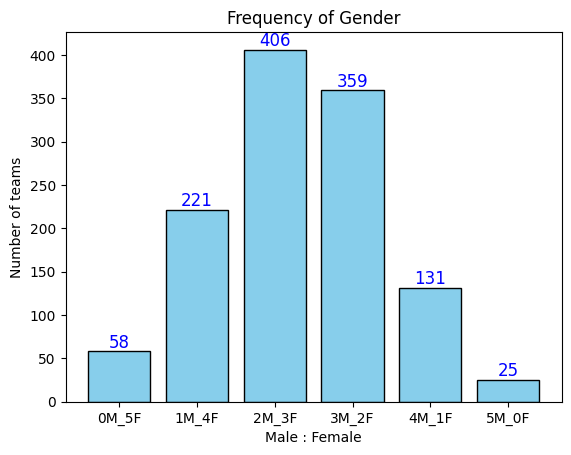

In [133]:
def plot_frequency_gender():
    data = frequency_gender(students_by_groups)
    x_labels = [value[0] for value in data]
    plt.bar(x_labels, [value[1] for value in data], color="skyblue", edgecolor="black")
    plt.title("Frequency of Gender")
    plt.xlabel("Male : Female")
    plt.ylabel("Number of teams")
    plt.xticks(ticks=range(len(data)), labels=x_labels)
    for i, value in enumerate(data):
        plt.text(
            i,
            value[1],
            str(value[1]),
            ha="center",
            va="bottom",
            fontsize=12,
            color="blue",
        )

    plt.show()


plot_frequency_gender()

#### Frequency school

We will do the same as the frequency of gender: We define `count[i][j]` as the number of teams with `i` students and `j` different schools

In [134]:
def frequency_school(group: dict[str, TutorialGroup]):

    count = {}
    for group_id, tutorial in group.items():
        for team_group in tutorial.students_by_teams.values():
            school = []
            for student in team_group.students:
                if student.school not in school:
                    school.append(student.school)
            if len(school) not in count:
                count[len(school)] = {}
                count[len(school)][len(team_group.students)] = 1
            else:
                if len(team_group.students) not in count[len(school)]:
                    count[len(school)][len(team_group.students)] = 1
                else:
                    count[len(school)][len(team_group.students)] += 1
    res = []
    for s in count.keys():
        for t in count[s].keys():
            res.append((f"{s}/{t}", count[s][t]))
    res.sort()
    return res

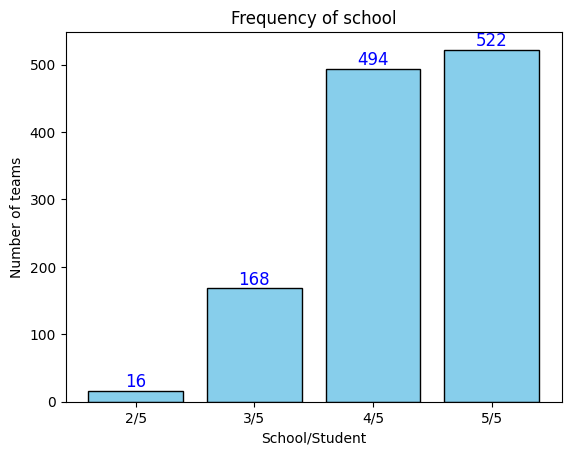

In [135]:
def plot_frequency_school():
    data = frequency_school(students_by_groups)
    x_labels = [value[0] for value in data]
    plt.bar(x_labels, [value[1] for value in data], color="skyblue", edgecolor="black")
    plt.title("Frequency of school")
    plt.xlabel("School/Student")
    plt.ylabel("Number of teams")
    plt.xticks(ticks=range(len(data)), labels=x_labels)
    for i, value in enumerate(data):
        plt.text(
            i,
            value[1],
            str(value[1]),
            ha="center",
            va="bottom",
            fontsize=12,
            color="blue",
        )

    plt.show()


plot_frequency_school()

#### Frequency CGPA

This plot is slightly different as we plot the difference between the average CGPA of a team and its corresponding tutorial group.

In [136]:
def frequency_cgpa(group: TutorialGroup):
    team_cnt = 0
    frequency = []
    for group_id, tutorial in group.items():
        team_cnt += 10
        for team_group in tutorial.students_by_teams.values():
            avg_team = team_group.get_avg_cgpa()
            avg_group = tutorial.get_avg_cgpa()
            frequency.append(abs(avg_team - avg_group))
    return frequency

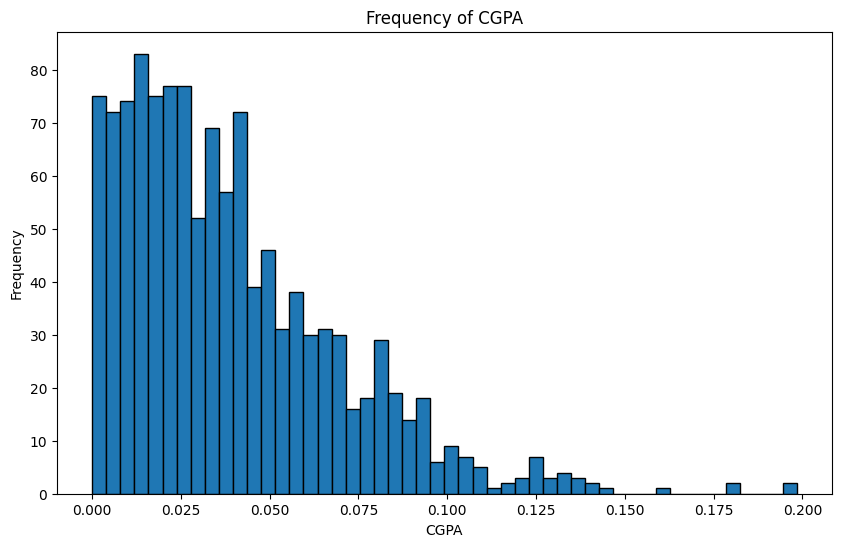

In [137]:
def plot_frequency_cgpa():

    data = frequency_cgpa(students_by_groups)
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, edgecolor="black")
    plt.title("Frequency of CGPA")
    plt.xlabel("CGPA")
    plt.ylabel("Frequency")
    plt.show()


plot_frequency_cgpa()

# Local Search

Local search is a heuristical algorithm to solve computationally hard optimisation problems. The term 'local' means that we only focus on finding solutions within limited part of the solution space.

We define a neighbour as a solution that is directly reachable from another solution by making a small change, in this case, it's the swap function. We will try to swap one student of a team with another student of a different team.

As we have defined earlier the evaluation function, or objective function. We will maximise the output of the function, so whenever we find a better neighbour, we keep the solution and keep finding if the neighbour of that neighbour yields better output.

This is a hill climbing method, and what we obtain will be the maximum solution in local solution space.

# Swap function

We first define our swap function for students across teams of the same group with the same TutorialGroup

In [138]:
class TutorialGroup:
    def __init__(self, group_id: int):
        self.group_id = group_id
        self.students_by_teams: Dict[int, TeamGroup] = {}
        self.students = []

    def __str__(self):
        return f"{self.group_id}:\n{[str(student) for student in self.students]}"

    def add_student(self, student: Student):
        self.students.append(student)

    def get_max_cgpa(self):
        return max(student.cgpa for student in self.students)

    def get_min_cgpa(self):
        return min(student.cgpa for student in self.students)

    def get_avg_cgpa(self) -> float:
        total_cgpa = sum(student.cgpa for student in self.students)
        return total_cgpa / len(self.students)

    def shuffle(self):
        random.shuffle(self.students)

    def assign_group(self, max_pax: int):
        self.shuffle()
        for i in range(0, len(self.students), max_pax):
            team_id = i // max_pax + 1
            self.students_by_teams[team_id] = TeamGroup(team_id, self.group_id)
            for j in range(i, i + max_pax):
                if j < len(self.students):
                    self.students[j].team_id = team_id
                    self.students_by_teams[team_id].add_student(self.students[j])
                else:
                    break

    def get_group_score(self):
        score = 0
        for team in self.students_by_teams.values():
            score += team.diversity_score()
        return score

    def swap(self, A: Student, B: Student):
        """Swapping student within the same group, but different teams
        Args:
            A (Student): The student A to be swapped
            B (Student): The student B to be swapped
        """
        ref_A = A.team_id
        ref_B = B.team_id
        A.team_id = ref_B
        B.team_id = ref_A
        self.students_by_teams[ref_A].students.remove(A)
        self.students_by_teams[ref_A].students.append(B)
        self.students_by_teams[ref_B].students.remove(B)
        self.students_by_teams[ref_B].students.append(A)


load_csv()

### Local Improve

Local improve functions will try to swap 2 students from different teams but in the same group. If the group score is higher, we keep the modification. Otherwise, we revert back to original.

In [139]:
def local_improve(group: TutorialGroup) -> bool:
    """Try to swap the target student with other students in the same group
    Args:
        group (TutorialGroup): The group where the student is in

    Returns:
        bool: If the group score is improved, return True, otherwise return False
    """
    initial_score = group.get_group_score()

    team_ids = list(group.students_by_teams.keys())
    
    improve = False
    for i in range(0, len(team_ids)):
        for j in range(i + 1, len(team_ids)):
            for student in group.students_by_teams[team_ids[i]].students:
                for other_student in group.students_by_teams[team_ids[j]].students:
                    group.swap(student, other_student)
                    new_score = group.get_group_score()
                    if new_score > initial_score:
                        initial_score = new_score
                        improve = True
                        break
                    else:
                        group.swap(student, other_student)
                continue
    return improve

### Group Improve

We will run the code until a specific number of swaps or until it reaches its local optima

In [ ]:
def group_improve(group: TutorialGroup):
    try:
        group_score = group.get_group_score()
        print(group.group_id, f"Before: {group_score}", end=" ")
        no_of_improve = 0
        # local_improve(group)
        while local_improve(group) and no_of_improve < 1:
            no_of_improve += 1
            pass
        group_score = group.get_group_score()
        print(f"After: {group_score}")
        print(f"Number of improvement: {no_of_improve}")
    except Exception as e:
        print(f"An error occurred in group {group.group_id}: {e}")

        print(traceback.format_exc())

### Run the code

We can now run the function for every group to check the score improvement. Because all groups are independent (We don't swap students across groups), we can do checking indepdendently for each group.

In [141]:
try:
    for group in students_by_groups.values():
        group.assign_group(5)
        group_improve(group)

except Exception as e:
    print(traceback.format_exc())

# for group in students_by_groups.values():
#     print(group.get_avg_cgpa())
#     for team in group.students_by_teams.values():
#         for student in team.students:
#             print(student)

G-1 Before: 126.48608975483326 After: 132.83572472482442
Number of improvement: 1
G-10 Before: 123.8991654547622 After: 132.94226552570768
Number of improvement: 1
G-100 Before: 125.28695271579913 After: 132.6420493513993
Number of improvement: 1
G-101 Before: 125.13043086846795 After: 133.70100957831687
Number of improvement: 1
G-102 Before: 124.68958903957409 After: 134.51929117661675
Number of improvement: 1
G-103 Before: 125.94475344592647 After: 132.68962606947395
Number of improvement: 1
G-104 Before: 125.0072207218243 After: 134.8986349002728
Number of improvement: 1
G-105 Before: 125.69977160578298 After: 134.2997033912283
Number of improvement: 1
G-106 Before: 127.11344318405766 After: 132.93556599755794
Number of improvement: 1
G-107 Before: 123.74095383389579 After: 137.1524543379621
Number of improvement: 1
G-108 Before: 126.86670965131279 After: 132.52784949727766
Number of improvement: 1
G-109 Before: 122.65854142964464 After: 135.7047004340601
Number of improvement: 1
G-

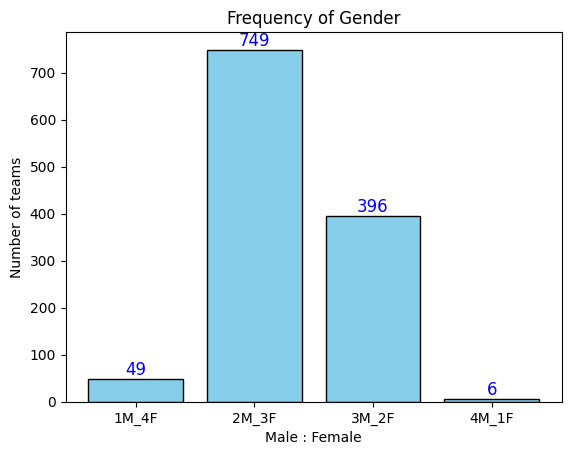

In [142]:
plot_frequency_gender()

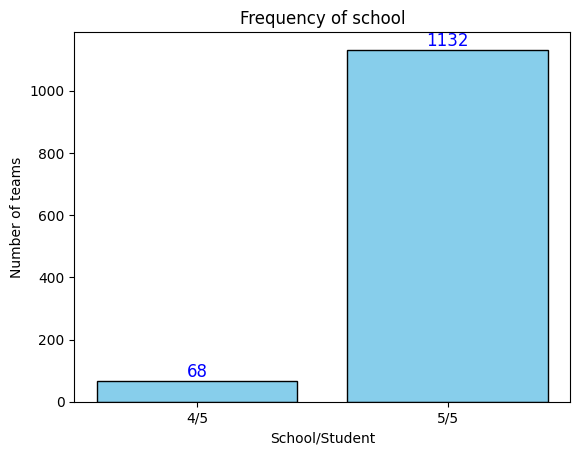

In [143]:
plot_frequency_school()

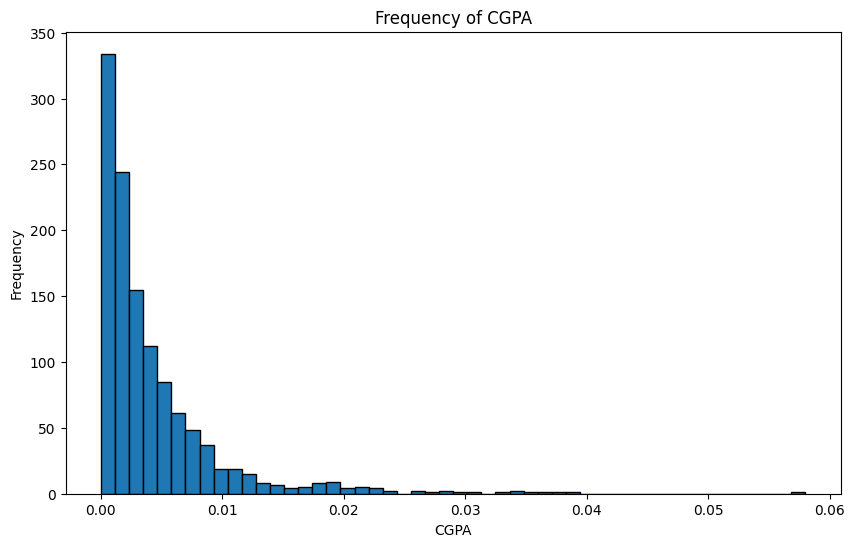

In [144]:
plot_frequency_cgpa()

In [ ]:
def get_team_size():
    while True:
        try:
            team_size = int(
                input("Enter a number of students per team (between 4 and 10): ")
            )
            if 4 <= team_size <= 10:
                return team_size
            else:
                print("Invalid input. Please enter a number between 4 and 10.")
        except ValueError:
            print("Invalid input. Please enter a number.")

# Extract new csv file

Finally, we output our result to a new csv file

In [147]:
def output_file():
    with open("output.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(
            ["Group ID", "Team ID", "Student ID", "School", "Name", "Gender", "CGPA"]
        )
        for group in students_by_groups.values():
            for team in group.students_by_teams.values():
                for student in team.students:
                    writer.writerow(
                        [
                            student.group_id,
                            student.team_id,
                            student.student_id,
                            student.school,
                            student.name,
                            student.gender,
                            student.cgpa,
                        ]
                    )

output_file()